###  Movie-Genre-Classifier-v3 - using Glove NLP Embedding


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer
import json
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Embedding, Input, Bidirectional, Dropout, Lambda, LayerNormalization
from tensorflow.keras.layers import GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Conv1D

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

In [2]:
movie_metadata_file = './data/movie.metadata.tsv'
movie_plot_file = './data/plot_summaries.txt'
glove_embd_file = "data/glove.6B.100d.txt"
model_file = './data/movie_model.h5'

In [3]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

VOCAB_WORDLIMIT = 100000
SEQUENCE_LEN = 2000
EMBD_SIZE = 100

BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 1e-3

top_genre = ['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'World cinema', 'Crime Fiction', 'Horror']

In [4]:
def clean_text(text):
 text = BeautifulSoup(text, "lxml").text
 text = text.lower() # lowercase text
 text = REPLACE_BY_SPACE_RE.sub(' ', text)
 text = BAD_SYMBOLS_RE.sub('', text)
 text = ' '.join(word for word in text.split() if word not in STOPWORDS)
 return text

In [5]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [6]:
def download_metadata(movie_metadata_file):
    df_metadata = pd.read_csv(movie_metadata_file, engine='python', sep = '\t', header = None,
                     quotechar='"', error_bad_lines=False, warn_bad_lines=False)
    df_metadata.head(2)    
    return df_metadata

In [7]:
df_metadata = download_metadata(movie_metadata_file)

In [8]:
def download_plot(movie_plot_file):
    df_plot = pd.read_csv(movie_plot_file, engine='python', sep = '\t', header = None,
                     quotechar='"', error_bad_lines=False, warn_bad_lines=False)
    df_plot.head(2)
    return df_plot

In [9]:
df_plot = download_plot(movie_plot_file)

In [10]:
def merge_plot_and_metadata():
    df_metadata.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
    df_plot.columns = ["movie_id", "plot"]
   
    df_dataset =  pd.merge(df_metadata[["movie_id","movie_name","genre"]],
                           df_plot[["movie_id", "plot"]], on="movie_id")
    return df_dataset


In [11]:
df_dataset = merge_plot_and_metadata()

In [12]:
def select_top_genre():
    genre_list = []
    for i in df_dataset['genre']:
        gen_filtered = []
        gen = json.loads(i).values()
        [gen_filtered.append(j) for j in list(gen) if j in top_genre]
        genre_list.append(gen_filtered)
    df_dataset['genre'] = genre_list
    df_dataset.head(2)
    return df_dataset

In [13]:
df_dataset = select_top_genre()

In [14]:
def clean_stem_plot_text():
    df_dataset['plot'] = df_dataset['plot'].apply(clean_text)
    df_dataset['plot'] = df_dataset['plot'].apply(stemming)
    return df_dataset


In [15]:
df_dataset = clean_stem_plot_text()

In [16]:
df_dataset

,movie_id,movie_name,genre,plot
0,975900,Ghosts of Mars,"[Thriller, Horror, Action]",set second half 22nd centuri film depict mar p...
1,9363483,White Of The Eye,[Thriller],seri murder rich young women throughout arizon...
2,261236,A Woman in Flames,[Drama],eva upper class housewif becom frustrat leav a...
3,18998739,The Sorcerer's Apprentice,[World cinema],everi hundr year evil morgana return claim fin...
4,6631279,Little city,"[Drama, Comedy, Romance Film]",adam san franciscobas artist work cab driver s...
...,...,...,...,...
42066,23851782,The Ghost Train,"[Crime Fiction, Thriller, Comedy]",plot film open great western express speed box...
42067,35228177,Mermaids: The Body Found,[Drama],two former nation ocean atmospher administr sc...
42068,34980460,Knuckle,[Drama],plot film follow 12 year live 3 irish travel f...
42069,913762,The Super Dimension Fortress Macross II: Lover...,[Drama],stori take place year 2092 super dimens fortre...


In [17]:
def append_columns_to_dataset(df, arr, col_names=[]):
    assert arr.shape[0]==len(df), "mismatch in number of rows"
    if col_names==[]:
        col_names = range(arr.shape[1])
    else:
        col_names = list(col_names)
    df_add = pd.DataFrame(arr, columns=col_names)
    
    df = pd.merge(df, df_add, how='left', left_index=True, right_index=True)

    print("df_add ->:", df_add.shape, "df ->:", df.shape, len(df))
    assert (df_add.shape[0]==len(df)), "mismatch in number of rows"
    assert (df_add.shape[1]==len(col_names)), "mismatch in number of columns"
    return df


In [18]:
def tokenize_plot(df):
    tokenizer = Tokenizer(num_words=VOCAB_WORDLIMIT,
                          filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df.values)
    plot_vocab = tokenizer.word_index

    X_plot_tokens = tokenizer.texts_to_sequences(df.values)
    X_plot_tokens = pad_sequences(X_plot_tokens, maxlen=SEQUENCE_LEN)
    
    print('X_plot_tokens:', type(X_plot_tokens), X_plot_tokens.shape)
    print("plot_vocab:{}, document_count:{}, largest word_index:{}, num_word: {}".format(
        type(plot_vocab),
        tokenizer.get_config()["document_count"],
        len(plot_vocab),
        tokenizer.get_config()["num_words"]))

    assert X_plot_tokens.shape==(len(df), SEQUENCE_LEN), "X_plot_tokens shape mismatch"
    
    return tokenizer, X_plot_tokens


In [19]:
tokenizer, X_plot_tokens = tokenize_plot(df_dataset['plot'])

X_plot_tokens: <class 'numpy.ndarray'> (42071, 2000)
plot_vocab:<class 'dict'>, document_count:42071, largest word_index:134441, num_word: 100000


In [20]:
df_dataset = append_columns_to_dataset(df_dataset, X_plot_tokens)

df_add ->: (42071, 2000) df ->: (42071, 2004) 42071


In [21]:
df_dataset

,movie_id,movie_name,genre,plot,0,1,2,3,4,5,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,975900,Ghosts of Mars,"[Thriller, Horror, Action]",set second half 22nd centuri film depict mar p...,0,0,0,0,0,0,...,139,89,143,5966,828,21,166,6829,84,758
1,9363483,White Of The Eye,[Thriller],seri murder rich young women throughout arizon...,0,0,0,0,0,0,...,748,188,7081,382,9347,1522,442,402,1750,2119
2,261236,A Woman in Flames,[Drama],eva upper class housewif becom frustrat leav a...,0,0,0,0,0,0,...,1774,86,199,29,110,297,8662,74672,74673,1063
3,18998739,The Sorcerer's Apprentice,[World cinema],everi hundr year evil morgana return claim fin...,0,0,0,0,0,0,...,920,681,668,40,1370,72,3705,967,116,93
4,6631279,Little city,"[Drama, Comedy, Romance Film]",adam san franciscobas artist work cab driver s...,0,0,0,0,0,0,...,742,842,1111,350,992,2317,151,2806,458,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42066,23851782,The Ghost Train,"[Crime Fiction, Thriller, Comedy]",plot film open great western express speed box...,0,0,0,0,0,0,...,1621,202,15,792,145,81,2829,12117,94,2282
42067,35228177,Mermaids: The Body Found,[Drama],two former nation ocean atmospher administr sc...,0,0,0,0,0,0,...,302,521,166,579,963,559,222,676,281,4605
42068,34980460,Knuckle,[Drama],plot film follow 12 year live 3 irish travel f...,0,0,0,0,0,0,...,204,1022,3889,1549,1215,713,496,810,188,29
42069,913762,The Super Dimension Fortress Macross II: Lover...,[Drama],stori take place year 2092 super dimens fortre...,0,0,0,0,0,0,...,3290,1402,876,28863,10765,13467,24245,63,29,148


In [22]:
def hot_multicode_utility(df):
    mlb = MultiLabelBinarizer()
    mlb.fit_transform(df)
    genres = mlb.classes_
    hot_multicode = mlb.transform(df)
    print('hot_multicode ->', type(hot_multicode), hot_multicode.shape, '\n',
         genres)
    assert (hot_multicode.shape[1]==len(top_genre)), "num of genre labels do not match with hot encoded list"
    assert (hot_multicode.shape[0]==len(df)), "inconsistent number of samples processed"
    return hot_multicode, genres


In [23]:
hot_multicode, genres = hot_multicode_utility(df_dataset['genre'])

hot_multicode -> <class 'numpy.ndarray'> (42071, 8) 
 ['Action' 'Comedy' 'Crime Fiction' 'Drama' 'Horror' 'Romance Film'
 'Thriller' 'World cinema']


In [24]:
df_dataset = append_columns_to_dataset(df_dataset, hot_multicode, col_names=genres)

/Users/bp/Environments/deep/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


df_add ->: (42071, 8) df ->: (42071, 2012) 42071


In [25]:
df_dataset

,movie_id,movie_name,genre,plot,0,1,2,3,4,5,...,1998,1999,Action,Comedy,Crime Fiction,Drama,Horror,Romance Film,Thriller,World cinema
0,975900,Ghosts of Mars,"[Thriller, Horror, Action]",set second half 22nd centuri film depict mar p...,0,0,0,0,0,0,...,84,758,1,0,0,0,1,0,1,0
1,9363483,White Of The Eye,[Thriller],seri murder rich young women throughout arizon...,0,0,0,0,0,0,...,1750,2119,0,0,0,0,0,0,1,0
2,261236,A Woman in Flames,[Drama],eva upper class housewif becom frustrat leav a...,0,0,0,0,0,0,...,74673,1063,0,0,0,1,0,0,0,0
3,18998739,The Sorcerer's Apprentice,[World cinema],everi hundr year evil morgana return claim fin...,0,0,0,0,0,0,...,116,93,0,0,0,0,0,0,0,1
4,6631279,Little city,"[Drama, Comedy, Romance Film]",adam san franciscobas artist work cab driver s...,0,0,0,0,0,0,...,458,34,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42066,23851782,The Ghost Train,"[Crime Fiction, Thriller, Comedy]",plot film open great western express speed box...,0,0,0,0,0,0,...,94,2282,0,1,1,0,0,0,1,0
42067,35228177,Mermaids: The Body Found,[Drama],two former nation ocean atmospher administr sc...,0,0,0,0,0,0,...,281,4605,0,0,0,1,0,0,0,0
42068,34980460,Knuckle,[Drama],plot film follow 12 year live 3 irish travel f...,0,0,0,0,0,0,...,188,29,0,0,0,1,0,0,0,0
42069,913762,The Super Dimension Fortress Macross II: Lover...,[Drama],stori take place year 2092 super dimens fortre...,0,0,0,0,0,0,...,29,148,0,0,0,1,0,0,0,0


In [26]:
def filter_unlabeled_data(df, start_col_index=df_dataset.columns.get_loc("Action")):
    df_bool = (df[df.columns[start_col_index::]] != 0).any(axis=1)
    df_filtered = df.loc[df_bool]
    print("len of filtered dataset {}, number of rows filtered out {}:".format(
        len(df_filtered), len(df)-len(df_filtered)))
    return df_filtered

In [27]:
df_dataset = filter_unlabeled_data(df_dataset)

len of filtered dataset 34561, number of rows filtered out 7510:


## Split dataset

In [28]:
df_X_plot = df_dataset.iloc[:,4:(4+SEQUENCE_LEN)]

In [29]:
df_Y_genre = df_dataset.iloc[:,(4+SEQUENCE_LEN)::]

In [30]:
def split_dataset(X_0, Y_0, residual_fraction):
    assert isinstance(X_0, pd.DataFrame), "X input should be a pandas dataframe"
    assert isinstance(Y_0, pd.DataFrame), "Y input should be a pandas dataframe"
    assert len(X_0)==len(Y_0), "num of samples in X input must be equal to that of Y input"
    X_1, X_2, Y_1, Y_2  = train_test_split(
        X_0, Y_0, test_size = residual_fraction, random_state = 42)
    
    print("total dataset items -> {}".format(len(X_0)))
    print("split values -> used:{}, remaing:{} ".format(len(Y_1), len(Y_2)))                   
    return X_1, X_2, Y_1, Y_2


In [31]:
X_train, X_pool, Y_train, Y_pool = split_dataset(df_X_plot, df_Y_genre, 0.05)

total dataset items -> 34561
split values -> used:32832, remaing:1729 


In [32]:
def print_genre_freq(df, start_col_idx=0):
    
    df = df[df.columns[start_col_idx::]]
    df = df.apply(pd.value_counts)
    df = df[1:2]
    df = df.sort_values(by =1,axis=1, ascending=False)
    df = df.transpose()
    sum_all = df.sum(axis = 0, skipna = True)
    print("genre freq for {} movies".format(Y_train.shape[0]))
    print(df)
    print(" col_tot", sum_all)
    
    return df

In [33]:
Y_train_genre_freq = print_genre_freq(Y_train)

genre freq for 32832 movies
                   1
Drama          18128
Comedy          9893
Romance Film    6301
Thriller        6210
Action          5561
World cinema    4880
Crime Fiction   4057
Horror          3869
 col_tot 1    58899
dtype: int64


In [34]:
def render_genre_freq(df):
    plt.figure(figsize=(12,6))
    ax = sns.barplot(data=df, x = list(df.index), y =df.iloc[:,0])
    ax.set(ylabel = "Train Set Movie Count", xlabel = "Train Set Genre")
    plt.show()
    return

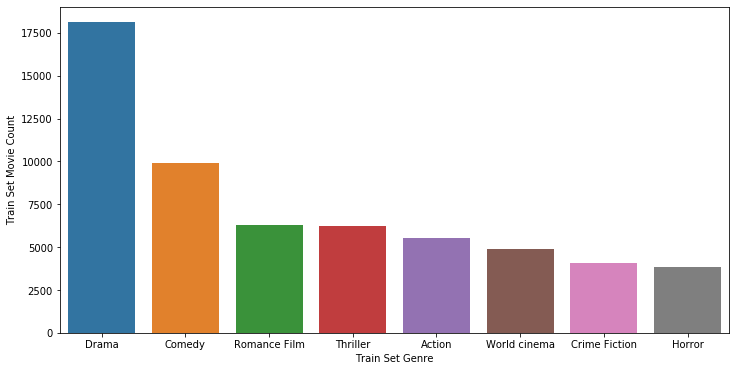

In [35]:
render_genre_freq(Y_train_genre_freq)

# Model

#### embedding_layer
* Turns positive integers (indexes) into dense vectors of fixed size
* This layer can only be used as the first layer in a model.
* Input shape:  2D tensor with shape: (batch_size, input_length)
* Output shape: 3D tensor with shape: (batch_size, input_length, output_dim).
#### LSTM
* Transform the vector sequence into a single vector, containing information about the entire sequence
#### Dropout
* A Simple Way to Prevent Neural Networks from Overfitting


In [36]:
#### Use pre-trained glove embeddings

In [37]:
def create_glove_embd(glove_embd_file):
    embeddings_index = {}
    with open(glove_embd_file, encoding='utf8') as f:
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            embed = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = embed
    word_index = tokenizer.word_index
    print("word_index length", len(word_index))
    num_words = min(VOCAB_WORDLIMIT, len(word_index) + 1)
    glove_embd = np.zeros((num_words, EMBD_SIZE), dtype='float32')
    print("glove_embd length", len(glove_embd))
    for word, i in word_index.items():
        if i >= VOCAB_WORDLIMIT:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            glove_embd[i] = embedding_vector
    return glove_embd


In [38]:
glove_embd = create_glove_embd(glove_embd_file)

word_index length 134441
glove_embd length 100000


#### Conv1D
* Conv1D was designed for a sequence analysis
* It works well for analysis of a time series over a fixed-length period
* 

In [39]:
def build_model():
    label_count = Y_train.shape[1]    
    x_plot_input = Input(shape=(SEQUENCE_LEN,))
    
    x = Embedding(VOCAB_WORDLIMIT, EMBD_SIZE, weights=[glove_embd], trainable=False, name='x_plot_input')(x_plot_input)
    x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    x = Conv1D(filters=64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    
    pred_label = Dense(label_count, activation="sigmoid", name='pred_label')(x)
    pred_count = Dense(label_count, activation="softmax", name='pred_count')(x)
    
    
    model = Model(x_plot_input, outputs=[pred_label, pred_count])
        
    return model


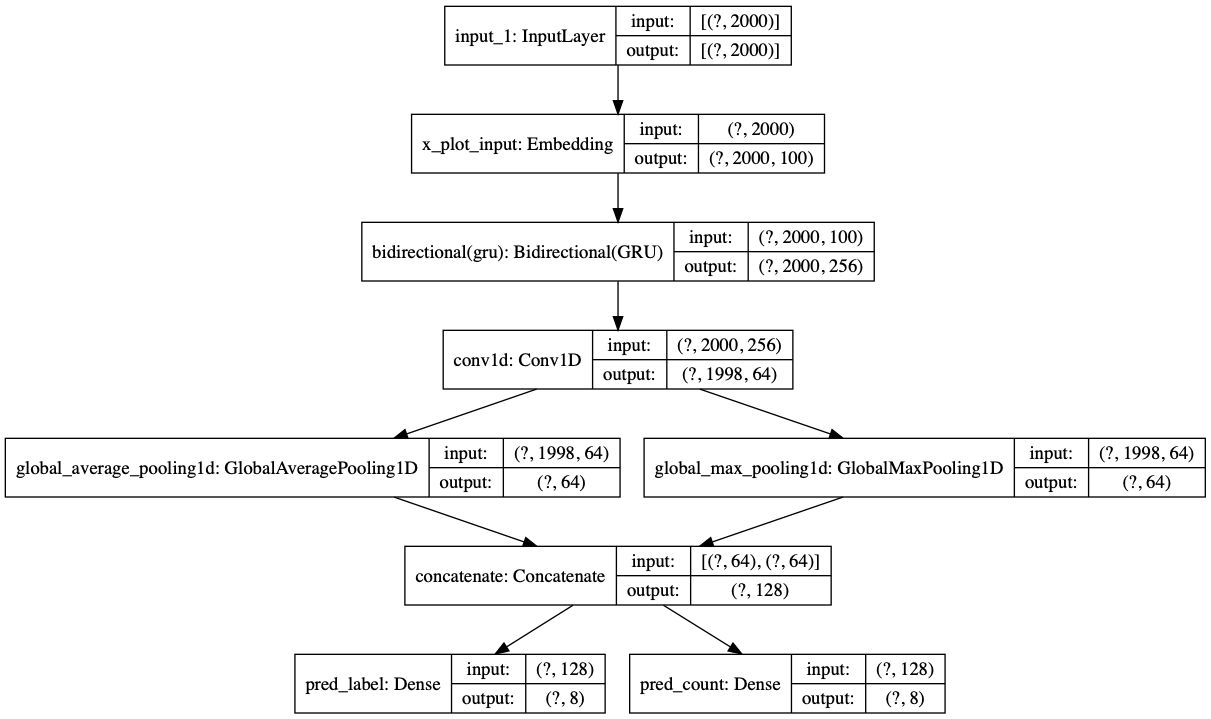

In [40]:
model = build_model()
plot_model(model, 'model.png', show_shapes=True)

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2000)]       0                                            
__________________________________________________________________________________________________
x_plot_input (Embedding)        (None, 2000, 100)    10000000    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 2000, 256)    176640      x_plot_input[0][0]               
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1998, 64)     49216       bidirectional[0][0]              
______________________________________________________________________________________________

In [42]:
def hot_onecode_utility(df):
    df = df.sum(axis=1)
    hot_onecode = to_categorical(df, num_classes=len(genres), dtype=int)
    print("hot_onecode ->", type(hot_onecode), hot_onecode.shape, "nulls=", df.isnull().sum())
    assert df.shape[0]==len(df), "out shape mismatch"
    return hot_onecode


In [43]:
model.compile(optimizer='adam',
              loss=({'pred_label': 'binary_crossentropy', 'pred_count': 'binary_crossentropy'}),
              loss_weights=({'pred_label': 1., 'pred_count': 1.}),
              metrics=({'pred_label': 'accuracy', 'pred_count': 'accuracy'}))

In [44]:
callbacks = [ReduceLROnPlateau(),
             EarlyStopping(patience=4),
             ModelCheckpoint(filepath=model_file, save_best_only=True)]

In [45]:
def train_model(X_train, Y_train):
    Y_train_count = hot_onecode_utility(Y_train)
    history = model.fit(X_train,
                        {'pred_label': Y_train, 'pred_count': Y_train_count},
                        batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2,
                        callbacks=callbacks)
    return history

In [46]:
history = train_model(X_train, Y_train)

hot_onecode -> <class 'numpy.ndarray'> (32832, 8) nulls= 0
Train on 26265 samples, validate on 6567 samples
Epoch 1/4
26265/26265 [==============================] - 4014s 153ms/sample - loss: 0.6567 - pred_label_loss: 0.4117 - pred_count_loss: 0.2450 - pred_label_accuracy: 0.8140 - pred_count_accuracy: 0.8816 - val_loss: 0.6283 - val_pred_label_loss: 0.3860 - val_pred_count_loss: 0.2428 - val_pred_label_accuracy: 0.8243 - val_pred_count_accuracy: 0.8808
Epoch 2/4
26265/26265 [==============================] - 3999s 152ms/sample - loss: 0.6125 - pred_label_loss: 0.3752 - pred_count_loss: 0.2373 - pred_label_accuracy: 0.8290 - pred_count_accuracy: 0.8860 - val_loss: 0.6214 - val_pred_label_loss: 0.3716 - val_pred_count_loss: 0.2504 - val_pred_label_accuracy: 0.8313 - val_pred_count_accuracy: 0.8733
Epoch 3/4
26265/26265 [==============================] - 3777s 144ms/sample - loss: 0.5953 - pred_label_loss: 0.3618 - pred_count_loss: 0.2334 - pred_label_accuracy: 0.8361 - pred_count_accura

In [47]:
[print(key) for key in history.history.keys()]

loss
pred_label_loss
pred_count_loss
pred_label_accuracy
pred_count_accuracy
val_loss
val_pred_label_loss
val_pred_count_loss
val_pred_label_accuracy
val_pred_count_accuracy
lr


[None, None, None, None, None, None, None, None, None, None, None]

In [48]:
def render_model_metrics(title, train_meas, val_meas):
    
    plt.plot(history.history[train_meas])
    plt.plot(history.history[val_meas])

    ylabel = str(train_meas).upper()
    
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('EPOCH')
    plt.legend([train_meas, val_meas], loc='lower right')
    plt.show()


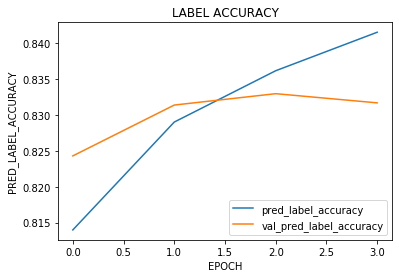

In [49]:
render_model_metrics('LABEL ACCURACY', 'pred_label_accuracy', 'val_pred_label_accuracy')

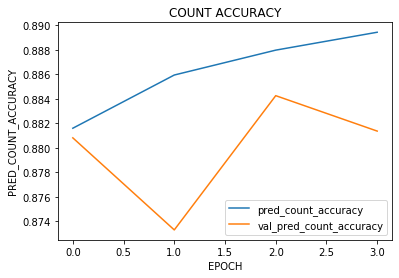

In [50]:
render_model_metrics('COUNT ACCURACY', 'pred_count_accuracy', 'val_pred_count_accuracy')

## Predictions Y_preds for X_test

In [51]:
TEST_SLICE = 8
def create_test_random(X_pool, Y_pool):
    assert isinstance(X_pool, pd.DataFrame), "X input should be a pandas dataframe"
    assert isinstance(Y_pool, pd.DataFrame), "Y input should be a pandas dataframe"
    XY_pool = X_pool.join(Y_pool)
    XY_test = XY_pool.sample(TEST_SLICE)
    X_test  = XY_test.iloc[:,0:SEQUENCE_LEN]
    Y_test  = XY_test.iloc[:,SEQUENCE_LEN:]
    print("X_test:", X_test.shape)
    print("Y_test:", Y_test.shape)

    return(X_test , Y_test )
    

In [52]:
X_test , Y_test  = create_test_random(X_pool, Y_pool)

X_test: (6, 2000)
Y_test: (6, 8)


In [53]:
def make_prediction(X_test):
    Y_preds = model.predict(X_test)
    print("Y_preds[0]:{} {}\nY_preds_count:{} {}".format(
        type(Y_preds[0]), Y_preds[0].shape, type(Y_preds[1]), Y_preds[1].shape))
    return Y_preds

In [54]:
Y_preds = make_prediction(X_test)

Y_preds[0]:<class 'numpy.ndarray'> (6, 8)
Y_preds_count:<class 'numpy.ndarray'> (6, 8)


## Results

In [55]:
def get_true_labels(test):
    true =[i for i in test.to_numpy()]
    true = np.array(true)
    
    true_labels = []
    for i, row in enumerate(true):
        arr = []
        for j, val in enumerate(row):
            if val==1:
                arr.append(genres[j])
        true_labels.append(arr)
    return true_labels

In [56]:
def get_pred_counts(counts):
    per_row_sum = [round((sum(row, 0))) for row in counts]
    #print("counts_prediction per_row_sum:", per_row_sum, "row_count: ", len(counts))
    assert (sum(per_row_sum)/len(counts)==1), "label_counts prabablity dists do not add to 100%"
    
    pred_counts = np.argmax(counts, axis=1)
    #print("labels counts model output -> argmax:{}\n{}".format(pred_counts, counts))
    return pred_counts

In [57]:
def get_pred_labels(labels):    
    labels_sorted_idx = np.argsort(-labels)
    labels_sorted = -np.sort(-labels)
    
    pred_counts = get_pred_counts(Y_preds[1])
            
    pred_labels = []
    for i, row_vals in enumerate(labels_sorted):
        #print("model output labels_sorted sample#{}\n{}".format( i, labels_sorted[i]))
        #print("labels_sorted idx\n{}".format(labels_sorted_idx[i]))
        #print("----------------------------")
        arr = []
        for j, row_val in enumerate(row_vals):
            label_idx = labels_sorted_idx[i,j]
            arr.append(genres[label_idx])
            if j+1== pred_counts[i]: break
        pred_labels.append(arr)

    return pred_labels

In [58]:
def print_final_results(test, preds):
    
    pred_labels = get_pred_labels(preds[0])
    pred_counts = [len(row) for row in pred_labels]
    
    true_labels = get_true_labels(test)   
    true_counts = [len(row) for row in true_labels]

    df_results = pd.DataFrame(columns=["true_labels", "pred_labels", "true_counts", "pred_counts"])
    df_results["true_labels"] = true_labels
    df_results["pred_labels"] = pred_labels
    df_results["true_counts"] = true_counts
    df_results["pred_counts"] = pred_counts
    return df_results

In [59]:
df_results = print_final_results(Y_test, Y_preds)

In [60]:
df_results

,true_labels,pred_labels,true_counts,pred_counts
0,[Drama],[Drama],1,1
1,"[Action, Comedy, Crime Fiction, Thriller]","[Thriller, Action, Crime Fiction]",4,3
2,[Horror],[Drama],1,1
3,[Comedy],[Comedy],1,1
4,[Comedy],[Comedy],1,1
5,[Drama],"[Drama, Romance Film]",1,2


#### Training Parms
* VOCAB_WORDLIMIT = 100,000
* SEQUENCE_LEN = 2000
* EMBD_SIZE = 100
* BATCH_SIZE = 32
* EPOCHS = 4
* LEARNING_RATE = 1e-3

* total dataset items -> 34561
* traning size -> used:32832, remaing:1729, training/validation split 80/20